In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
"""
OD_Matrix_pc_75.csv
population_pt_75.csv
OD_Matrix_pt_75.csv
population_pc_75.csv
population.csv
"""

percent_pop = "base"
folder = "basecase"
incubation = 7
iterations = 3000

melbourne_pc = pd.read_csv('data/'+folder+'/population_pc_'+percent_pop+'.csv', sep=',',header=None)
pop_pc       = melbourne_pc.values
pop_pc       = np.nan_to_num(pop_pc, copy = True)
pop_pc       = pop_pc.astype(int)

od_matrix_pc = genfromtxt('data/'+folder+'/OD_Matrix_pc_'+percent_pop+'.csv', delimiter=',')
od_matrix_pc = np.reshape(od_matrix_pc, (12,309,309))
od_matrix_pc = np.nan_to_num(od_matrix_pc, copy = True)
od_matrix_pc = od_matrix_pc.astype(int)

melbourne_pt = pd.read_csv('data/'+folder+'/population_pt_'+percent_pop+'.csv', sep=',',header=None)
pop_pt       = melbourne_pt.values
pop_pt       = np.nan_to_num(pop_pt, copy = True)
pop_pt       = pop_pt.astype(int)

od_matrix_pt = genfromtxt('data/'+folder+'/OD_Matrix_pt_'+percent_pop+'.csv', delimiter=',')
od_matrix_pt = np.reshape(od_matrix_pt, (12,309,309))
od_matrix_pt = np.nan_to_num(od_matrix_pt, copy = True)
od_matrix_pt = od_matrix_pt.astype(int)

#At this point only have 25% for pop and flow, now we scale them up


pop_pc = pop_pc*4
od_matrix_pc = od_matrix_pc*4

pop_pt = pop_pt*4
od_matrix_pt = od_matrix_pt*4

for i in range(1,12):
    pop_pc[i,:] = pop_pc[0,:]
    pop_pt[i,:] = pop_pt[0,:]

to_this_origin_pc   = np.sum(od_matrix_pc,axis = 1)
from_this_origin_pc = np.sum(od_matrix_pc,axis = 2)

to_this_origin_pt   = np.sum(od_matrix_pt,axis = 1)
from_this_origin_pt = np.sum(od_matrix_pt,axis = 2)

import numpy as np
import pickle 
import matplotlib.pyplot as plt
import random
from collections import namedtuple


Param = namedtuple('Param', 'R0 DI I0 HospitalisationRate HospiterIters')

random.seed(30)

OD_id = [p for p in range (0,309)]

r = od_matrix_pc.shape[0]
n = pop_pc.shape[1]

initialInd = random.sample(OD_id,20)
initial = np.zeros(n)
initial[initialInd] = 15

model = Param(R0 = 2.4, DI = incubation*12, I0 = initial, HospitalisationRate=0.1,HospiterIters=15*12)

%run SIR-mobility-mode.py

res = {}

inf = 10

res['baseline'] = sir(model,pop_pc,od_matrix_pc,pop_pt,od_matrix_pt,iterations,inf)


/Users/cptnemo2005/Desktop/SEIR/SIR-mobility-mode.py:54: RuntimeWarning: invalid value encountered in true_divide
  realflow_pc = realflow_pc / realflow_pc.sum(axis=2)[:,:, np.newaxis]
/Users/cptnemo2005/Desktop/SEIR/SIR-mobility-mode.py:57: RuntimeWarning: invalid value encountered in true_divide
  realflow_pt = realflow_pt / realflow_pt.sum(axis=2)[:,:, np.newaxis]


In [79]:

newI_inf = res['baseline'][4] + res['baseline'][5] 

newI_inf.astype(int)

newI_inf = np.sum(newI_inf,axis=0)

In [80]:
newI = newI_inf  
newI = newI.astype(int)


In [81]:
print(min(newI))
max(newI)

1268


34467

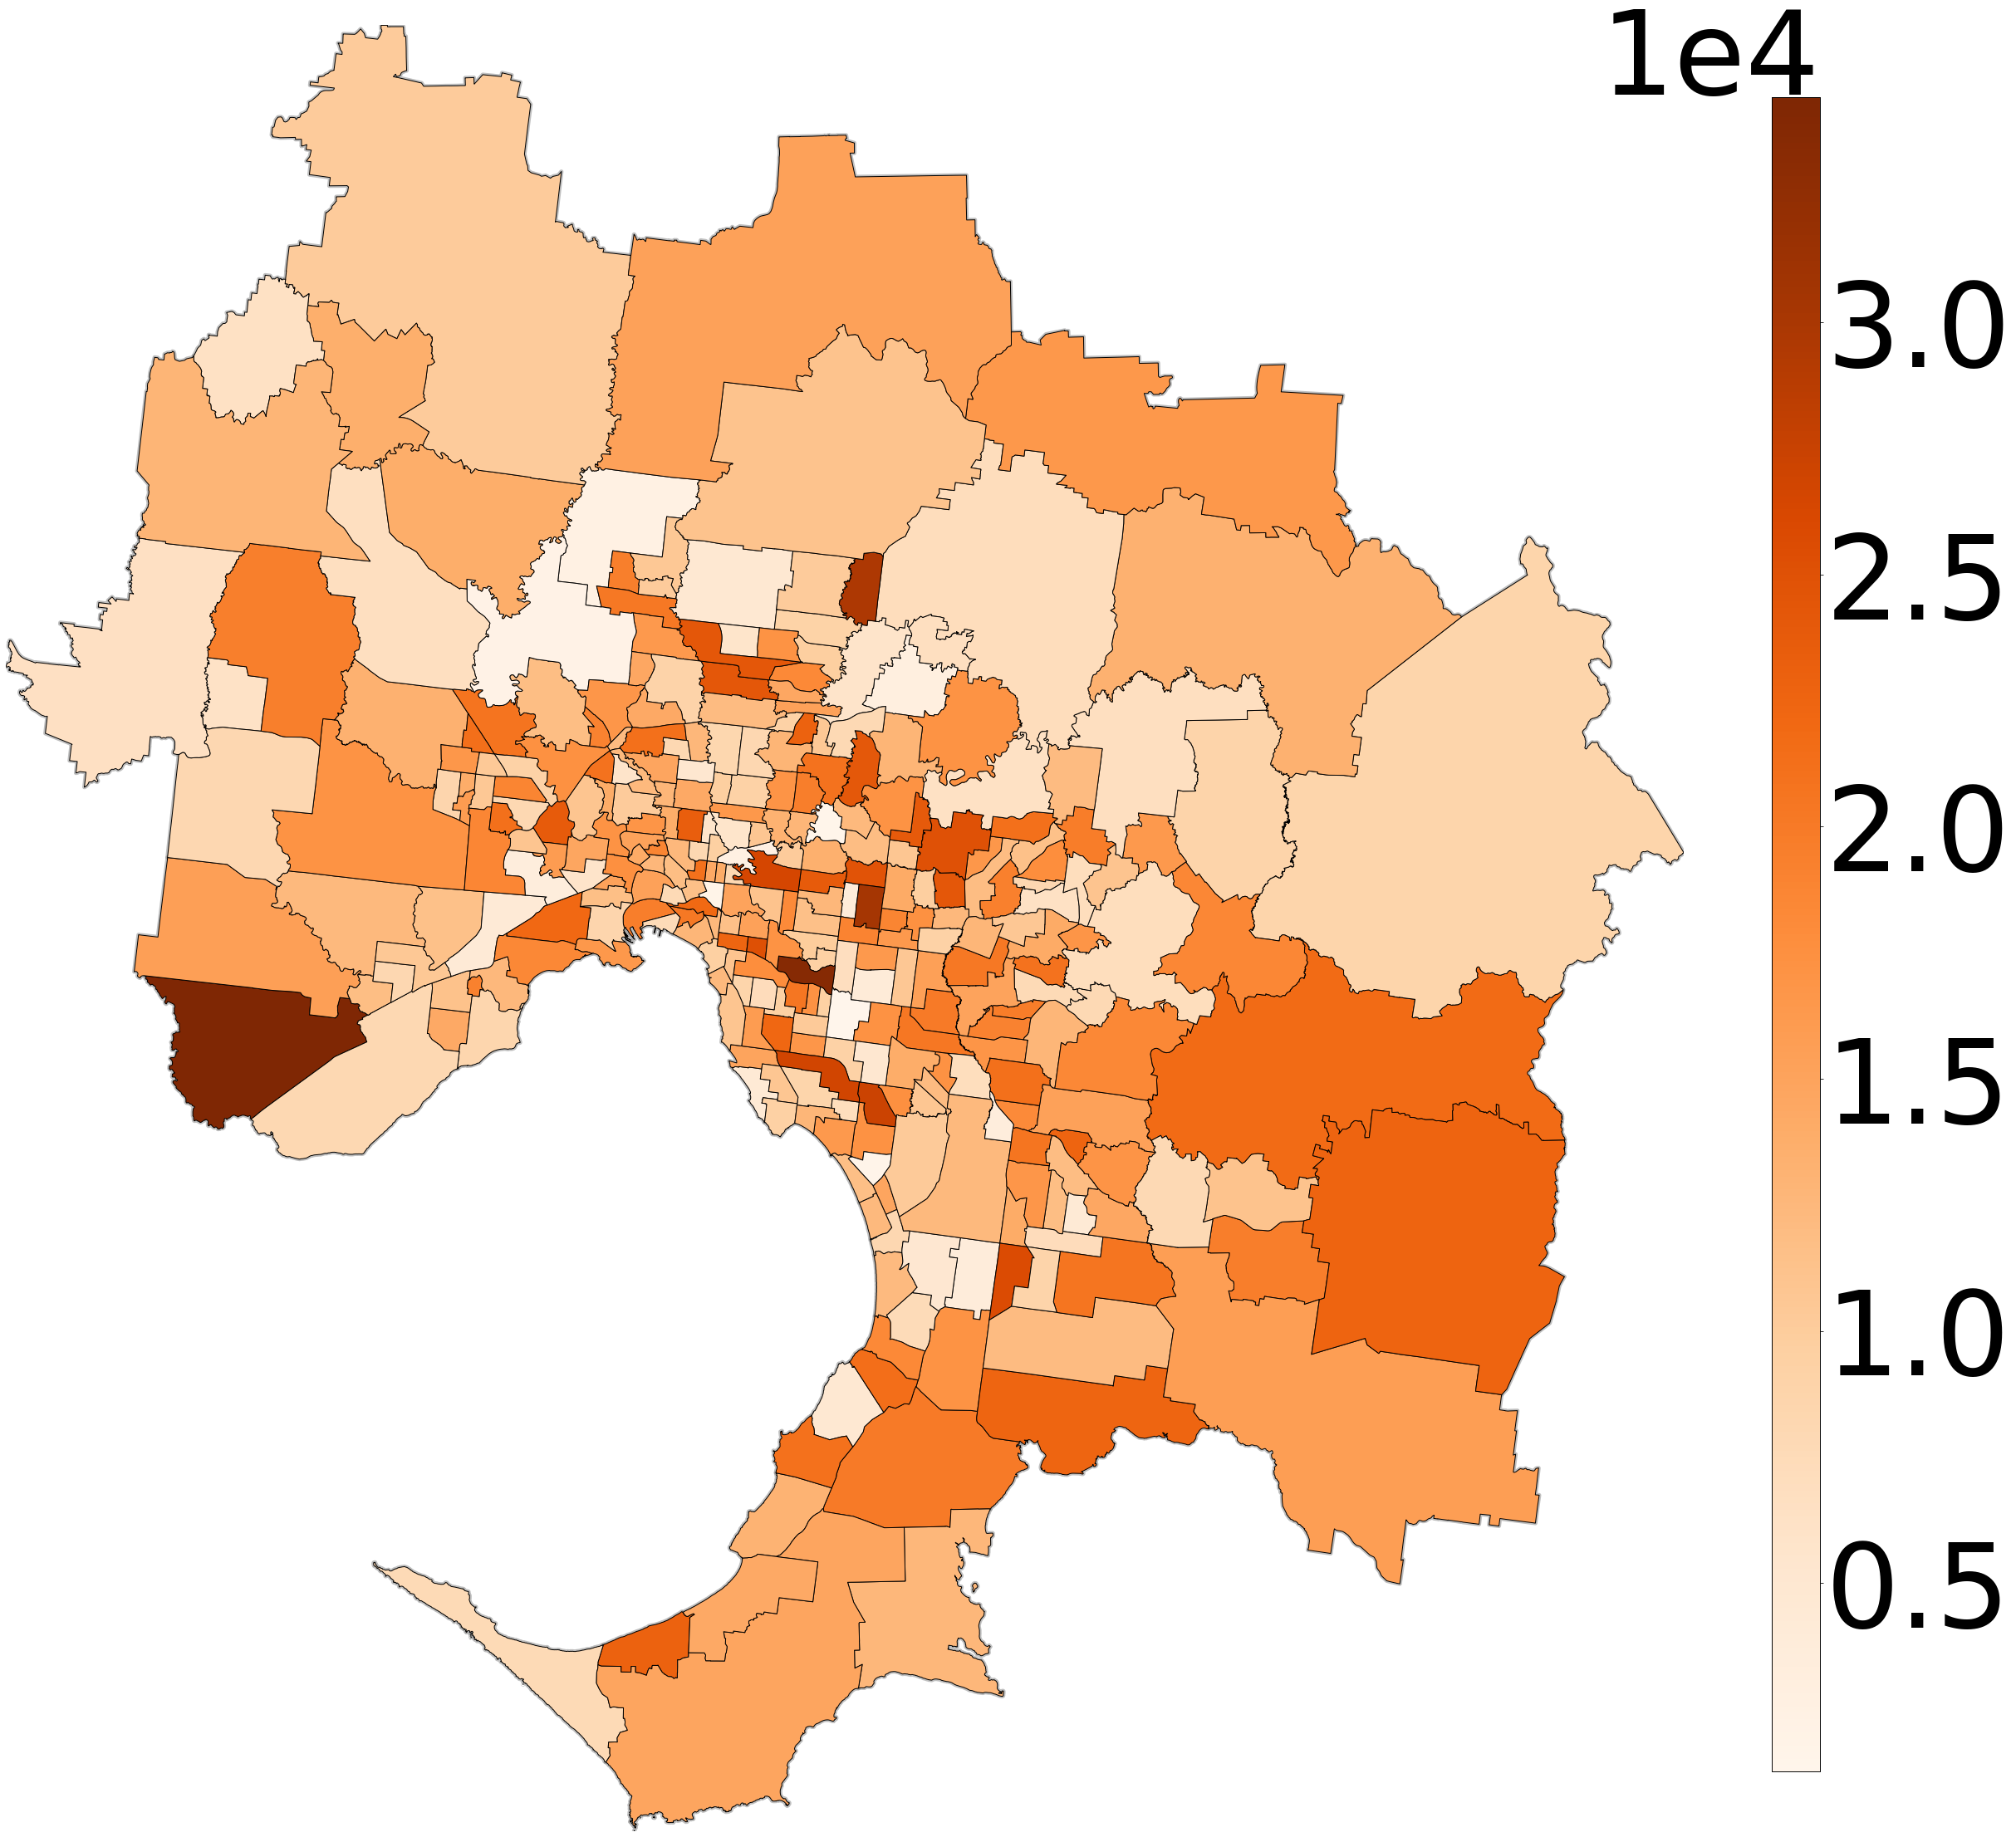

In [82]:
import geopandas as gpd
import contextily as ctx
from matplotlib.colors import LinearSegmentedColormap

melbourne_gpd = gpd.read_file("/Users/cptnemo2005/Downloads/shapefiles/SA2_studyarea_16_z55.shp")
melbourne_gpd['population'] = newI

plt.rcParams.update({'font.size':32})
west,south,east,north = melbourne_gpd.unary_union.bounds

fig,ax = plt.subplots(figsize=(40,40))


#cmap = LinearSegmentedColormap.from_list('mycmap', ['green','white' ])
#cmap = LinearSegmentedColormap.from_list('mycmap', ['green','white','red'])
melbourne_gpd.plot(ax=ax,facecolor='none',edgecolor='gray',alpha=0.5,linewidth=5,zorder=2)
melbourne_gpd.plot(ax=ax, column='population',legend=False,edgecolor='black',cmap='Oranges',zorder=3,\
                   norm=plt.Normalize(vmin=1268,vmax=34467))
cbax = fig.add_axes([0.9,0.15,0.02,0.7])

sm = plt.cm.ScalarMappable(cmap='Oranges',\
                          norm=plt.Normalize(vmin=1268,vmax=34467))

sm._A=[]

fig.colorbar(sm,cax=cbax,format="%d")

ax.set_xlim(west,east)
ax.set_ylim(south,north)
cbar = fig.colorbar(sm,cax=cbax,format=OOMFormatter(4,mathText=False))

cbar.ax.yaxis.get_offset_text().set_fontsize(140)
cbar.ax.tick_params(labelsize=140)


ax.axis('off')

plt.savefig('/Users/cptnemo2005/new_results/' +'base_case_mobility'+str(iterations)+'.jpg')


plt.show()

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
            self.format = r'$\mathdefault{%s}$' % self.format